In [37]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("predict_insurance_costs").getOrCreate()


data = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("/home/thuanan/Downloads/insurance.csv")


data.cache()
# so dong du lieu
data.count()

1338

In [38]:
display(data)

data.printSchema()

DataFrame[age: int, sex: string, bmi: double, children: int, smoker: string, region: string, charges: double]

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [39]:
data.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [40]:
# Mo ta ve tap du lieu
data.describe().show()
data.createOrReplaceTempView("insurance")
spark.sql("SELECT count(region), region FROM insurance group by region order by region").show(100)

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+

+-------------+---

In [41]:
data.createOrReplaceTempView("insurance")
# Chuyen doi cac thuoc tinh dang string sang numberic
from pyspark.ml.feature import StringIndexer
# I. With SEX
# Create StringIndexer
sex_indexer = StringIndexer(inputCol = "sex", \
                             outputCol = "sex_index")


# II. With SMOKER
# Create StringIndexer
smoker_indexer = StringIndexer(inputCol = "smoker", \
                             outputCol = "smoker_index")

# III. With REGION
# Create StringIndexer
region_indexer = StringIndexer(inputCol = "region", \
                            outputCol = "region_index")


In [42]:
# Make a VectorAssembler de gom cac thuoc tinh de du doan vao mot features
from pyspark.ml.feature import VectorAssembler
vec_assembler = VectorAssembler(inputCols = ["age", "sex_index", "bmi", \
                                             "children", "smoker_index",\
                                             "region_index"], 
                                outputCol = "features")

In [43]:
#Chuyen doi du lieu model thong qua pipeline
from pyspark.ml import Pipeline

# Make a pipeline
flights_sea_pipe  = Pipeline(stages = [sex_indexer, smoker_indexer, \
                                       region_indexer,vec_assembler])

In [44]:
# create pipe_data from pipeline
pipe_data = flights_sea_pipe.fit(data).transform(data)


In [45]:
pipe_data.select("features").show()

+--------------------+
|            features|
+--------------------+
|[19.0,1.0,27.9,0....|
|[18.0,0.0,33.77,1...|
|[28.0,0.0,33.0,3....|
|[33.0,0.0,22.705,...|
|[32.0,0.0,28.88,0...|
|[31.0,1.0,25.74,0...|
|[46.0,1.0,33.44,1...|
|[37.0,1.0,27.74,3...|
|[37.0,0.0,29.83,2...|
|[60.0,1.0,25.84,0...|
|[25.0,0.0,26.22,0...|
|[62.0,1.0,26.29,0...|
|[23.0,0.0,34.4,0....|
|[56.0,1.0,39.82,0...|
|[27.0,0.0,42.13,0...|
|[19.0,0.0,24.6,1....|
|[52.0,1.0,30.78,1...|
|[23.0,0.0,23.845,...|
|[56.0,0.0,40.3,0....|
|[30.0,0.0,35.3,0....|
+--------------------+
only showing top 20 rows



In [46]:
pipe_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)
 |-- sex_index: double (nullable = false)
 |-- smoker_index: double (nullable = false)
 |-- region_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [47]:
# Tao tap du lieu train va test
data_train, data_test = pipe_data.randomSplit([0.8, 0.2])
data_train.show(5)
data_test.show(5)

+---+------+------+--------+------+---------+----------+---------+------------+------------+--------------------+
|age|   sex|   bmi|children|smoker|   region|   charges|sex_index|smoker_index|region_index|            features|
+---+------+------+--------+------+---------+----------+---------+------------+------------+--------------------+
| 18|female| 20.79|       0|    no|southeast| 1607.5101|      1.0|         0.0|         0.0|[18.0,1.0,20.79,0...|
| 18|female| 21.66|       0|   yes|northeast|14283.4594|      1.0|         1.0|         3.0|[18.0,1.0,21.66,0...|
| 18|female| 24.09|       1|    no|southeast| 2201.0971|      1.0|         0.0|         0.0|[18.0,1.0,24.09,1...|
| 18|female| 25.08|       0|    no|northeast| 2196.4732|      1.0|         0.0|         3.0|[18.0,1.0,25.08,0...|
| 18|female|26.315|       0|    no|northeast|2198.18985|      1.0|         0.0|         3.0|[18.0,1.0,26.315,...|
+---+------+------+--------+------+---------+----------+---------+------------+---------

In [48]:
class GDLinearRegression:
    def __init__(self, lr, step):
        '''
        Khởi tạo learning rate và số lượng step update weigh
        '''
        self.lr = lr
        self.step = step
        
    def fit(self, X, y):
        ''' 
        Train the model với đầu vào là tập train data X cùng nhãn Y
        X là ma trận MxN trong đó M là số lượng điểm dữ liệu, mỗi điểm dữ liệu có N chiều.
        Trường hợp dữ liệu 1 chiều thì X là vector cột Mx1
        '''
        # lấy ra số lượng điểm train_size và số chiều dữ liệu n_features
        self.n_features = X.shape[1] if len(X.shape) > 1 else 1 
        train_size = len(X) # số lượng sample
        
        # chuẩn hóa lại định dạng dữ liệu
        X = X.reshape(-1, self.n_features)
        y = y.reshape([-1, 1])
        
        # ta muốn thực hiện dự đoán y = X.T*W + bias, ta đưa bias vào W (W|bias) và 1 cột toàn 1 vào X (X|one),
        # lúc đó việc tính toán thuận tiện hơn y = (X|one).T*(W|bias) => đây là trick để tính toán cho nhanh
        one = np.ones([train_size, 1])
        X = np.concatenate([X, one], 1)
        
        # tạo weight chính là parameters ta sẽ optimize trong quá trình train
        self.weight = np.zeros([self.n_features + 1, 1])
        print('x shape: ', X.shape, '- y shape: ', y.shape, '- weight shape: ', self.weight.shape, 'train_size: ', train_size)
        
        # mảng lưu lại toàn bộ giá trị loss trong quá trình train
        self.train_loss = []
        
        # train
        for i in range(self.step):
            
            loss = np.sum((y - np.dot(X, self.weight)) ** 2)
            delta = np.dot(X.T, ( np.dot(X, self.weight) - y))
            
            # update weight
            self.weight = self.weight - (self.lr/train_size) * delta
            
            # tính trung bình loss
            loss = loss/train_size
            self.train_loss.append(loss.item())
    
    def predict(self, X):
        '''
        Thực hiện dự đoán
        '''
        # chuẩn hóa format dữ liệu như ta đã làm trong lúc train
        X = X.reshape(-1, self.n_features)
        
        # thêm cột one như ta đã làm trong lúc train
        one = np.ones([len(X), 1])
        X = np.concatenate([X, one], 1)
        
        # thực hiện dự đoán, đơn giản là nhân ma trận
        y_hat = np.dot(X, self.weight)
        
        return y_hat
    
    def print_weight(self):
        '''
        In weigt đã học được
        '''
        print(self.weight)
        
    def get_train_loss(self):
        '''
        Trả về train loss đã lưu trong quá trình train
        '''
        return self.train_loss

In [49]:
X_train  = data_train.select("age", "sex_index", "bmi","children", "smoker_index","region_index")

y_train  = data_train.select("charges")

X_test  = data_test.select("age", "sex_index", "bmi","children", "smoker_index","region_index")

y_test  = data_test.select("charges")


In [50]:
model = GDLinearRegression(0.0001, 1000)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))


x shape:  (1053, 7) - y shape:  (1053, 1) - weight shape:  (7, 1) train_size:  1053


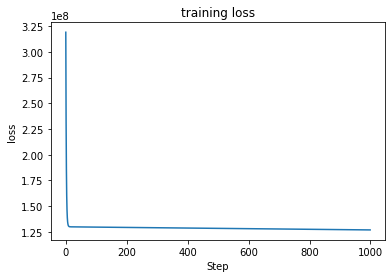

last loss:  126757192.38034722
[[ 8200.50161176 21344.8467    ]
 [ 8228.25703685  2203.73595   ]
 [ 9005.40893938  2211.13075   ]
 [ 9591.16350122 14133.03775   ]
 [ 9671.53914154  2217.46915   ]
 [ 9880.40424689  1634.5734    ]
 [ 6175.67889109  1694.7964    ]
 [ 7202.62961942  1704.5681    ]
 [ 7216.50733197  1704.70015   ]
 [ 8854.94248134 33732.6867    ]
 [ 9071.70738873  1137.4697    ]
 [ 9489.49957693  1141.4451    ]
 [10325.08395333  1149.3959    ]
 [ 6809.71317581  1728.897     ]
 [ 7641.60073282  2913.569     ]
 [ 7804.37158473  2709.1119    ]
 [ 7700.80840239  1737.376     ]
 [ 8543.83150116 16884.924     ]
 [ 8669.69445904 17468.9839    ]
 [ 9436.8538177  34439.8559    ]
 [ 9667.88142753 36397.576     ]
 [ 9293.32645452  2134.9015    ]
 [ 9626.39155561  2138.0707    ]
 [ 7504.42484712  1628.4709    ]
 [ 8557.57171277 16297.846     ]
 [ 8670.15270091  1639.5631    ]
 [ 9240.00398431 33750.2918    ]
 [ 9160.75234239  1261.859     ]
 [ 9594.74812403 34779.615     ]
 [ 8641.9729

In [51]:
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("Step")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))

print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()

In [52]:

#plt.plot(X_test.collect(), y_hat, color="blue")
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()

In [53]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(np.array(y_test.collect()), y_hat)
print(mse)

131296242.28824149


x shape:  (1053, 2) - y shape:  (1053, 1) - weight shape:  (2, 1) train_size:  1053


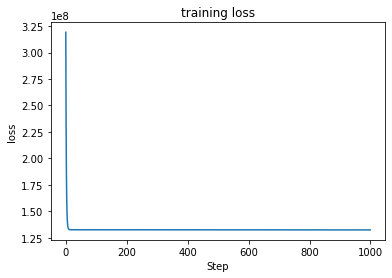

last loss:  132520525.23921834
[[ 6069.53845446 21344.8467    ]
 [ 6069.53845446  2203.73595   ]
 [ 6069.53845446  2211.13075   ]
 [ 6069.53845446 14133.03775   ]
 [ 6069.53845446  2217.46915   ]
 [ 6069.53845446  1634.5734    ]
 [ 6069.53845446  1694.7964    ]
 [ 6069.53845446  1704.5681    ]
 [ 6069.53845446  1704.70015   ]
 [ 6069.53845446 33732.6867    ]
 [ 6069.53845446  1137.4697    ]
 [ 6069.53845446  1141.4451    ]
 [ 6069.53845446  1149.3959    ]
 [ 6390.89106612  1728.897     ]
 [ 6390.89106612  2913.569     ]
 [ 6390.89106612  2709.1119    ]
 [ 6390.89106612  1737.376     ]
 [ 6390.89106612 16884.924     ]
 [ 6390.89106612 17468.9839    ]
 [ 6390.89106612 34439.8559    ]
 [ 6390.89106612 36397.576     ]
 [ 6390.89106612  2134.9015    ]
 [ 6390.89106612  2138.0707    ]
 [ 6390.89106612  1628.4709    ]
 [ 6390.89106612 16297.846     ]
 [ 6390.89106612  1639.5631    ]
 [ 6390.89106612 33750.2918    ]
 [ 6390.89106612  1261.859     ]
 [ 6390.89106612 34779.615     ]
 [ 6712.2436

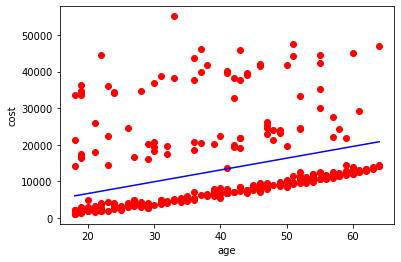

In [59]:
#Age and Insurance Cost
X_train  = data_train.select("age")
X_test  = data_test.select("age")
model = GDLinearRegression(0.001, 1000)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("Step")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('age')
plt.ylabel('cost')
plt.show()

x shape:  (1053, 2) - y shape:  (1053, 1) - weight shape:  (2, 1) train_size:  1053


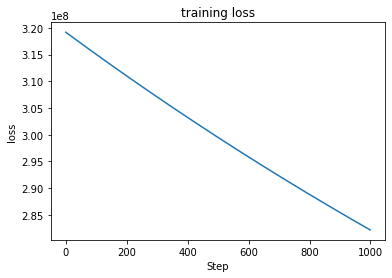

last loss:  282190355.21332866
[[ 1800.03306731 21344.8467    ]
 [ 1800.03306731  2203.73595   ]
 [ 1800.03306731  2211.13075   ]
 [ 1800.03306731 14133.03775   ]
 [ 1800.03306731  2217.46915   ]
 [ 1800.03306731  1634.5734    ]
 [ 1237.55160922  1694.7964    ]
 [ 1237.55160922  1704.5681    ]
 [ 1237.55160922  1704.70015   ]
 [ 1237.55160922 33732.6867    ]
 [ 1237.55160922  1137.4697    ]
 [ 1237.55160922  1141.4451    ]
 [ 1237.55160922  1149.3959    ]
 [ 1800.03306731  1728.897     ]
 [ 1800.03306731  2913.569     ]
 [ 1800.03306731  2709.1119    ]
 [ 1800.03306731  1737.376     ]
 [ 1800.03306731 16884.924     ]
 [ 1800.03306731 17468.9839    ]
 [ 1800.03306731 34439.8559    ]
 [ 1800.03306731 36397.576     ]
 [ 1800.03306731  2134.9015    ]
 [ 1800.03306731  2138.0707    ]
 [ 1237.55160922  1628.4709    ]
 [ 1237.55160922 16297.846     ]
 [ 1237.55160922  1639.5631    ]
 [ 1237.55160922 33750.2918    ]
 [ 1237.55160922  1261.859     ]
 [ 1237.55160922 34779.615     ]
 [ 1800.0330

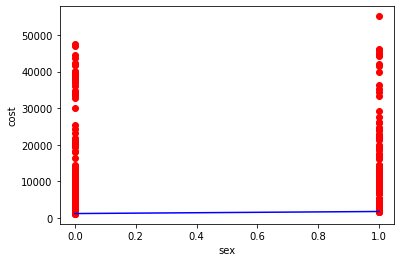

In [66]:
#sex and Insurance Cost
X_train  = data_train.select("sex_index")
X_test  = data_test.select("sex_index")
model = GDLinearRegression(0.0001, 1000)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("Step")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('sex')
plt.ylabel('cost')
plt.show()

x shape:  (1053, 2) - y shape:  (1053, 1) - weight shape:  (2, 1) train_size:  1053


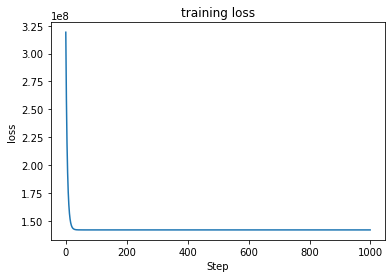

last loss:  141704579.39126107
[[12810.93635673 21344.8467    ]
 [12891.62624506  2203.73595   ]
 [15150.94311821  2211.13075   ]
 [16278.47813667 14133.03775   ]
 [17087.50043805  2217.46915   ]
 [17119.35170976  1634.5734    ]
 [ 6799.53967638  1694.7964    ]
 [ 9785.06554447  1704.5681    ]
 [ 9825.41048864  1704.70015   ]
 [13496.80040751 33732.6867    ]
 [14643.44618899  1137.4697    ]
 [15858.04135012  1141.4451    ]
 [18287.23167238  1149.3959    ]
 [ 7920.7044405   1728.897     ]
 [ 9959.18582981  2913.569     ]
 [10430.58465109  2709.1119    ]
 [10511.27453942  1737.376     ]
 [11870.26213229 16884.924     ]
 [12044.38241762 17468.9839    ]
 [14082.86380693 34439.8559    ]
 [14758.11076714 36397.576     ]
 [14949.21839739  2134.9015    ]
 [15917.49705731  2138.0707    ]
 [ 9623.68576782  1628.4709    ]
 [11785.32540773 16297.846     ]
 [13012.66107755  1639.5631    ]
 [13577.49029583 33750.2918    ]
 [14630.70568031  1261.859     ]
 [14800.57912942 34779.615     ]
 [12592.2242

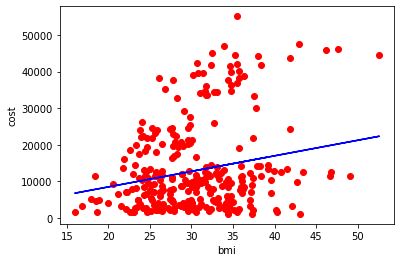

In [61]:
#bmi and Insurance Cost
X_train  = data_train.select("bmi")
X_test  = data_test.select("bmi")
model = GDLinearRegression(0.0001, 1000)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("Step")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('bmi')
plt.ylabel('cost')
plt.show()

x shape:  (1053, 2) - y shape:  (1053, 1) - weight shape:  (2, 1) train_size:  1053


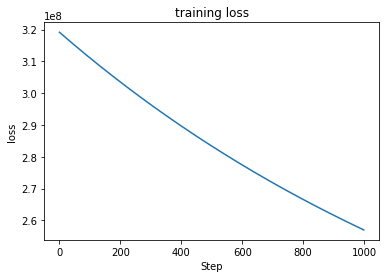

last loss:  256974998.62471482
[[ 1177.18342082 21344.8467    ]
 [ 1177.18342082  2203.73595   ]
 [ 1177.18342082  2211.13075   ]
 [ 1177.18342082 14133.03775   ]
 [ 1177.18342082  2217.46915   ]
 [ 1177.18342082  1634.5734    ]
 [ 1177.18342082  1694.7964    ]
 [ 1177.18342082  1704.5681    ]
 [ 1177.18342082  1704.70015   ]
 [ 1177.18342082 33732.6867    ]
 [ 1177.18342082  1137.4697    ]
 [ 1177.18342082  1141.4451    ]
 [ 1177.18342082  1149.3959    ]
 [ 1177.18342082  1728.897     ]
 [ 3785.84216594  2913.569     ]
 [ 2481.51279338  2709.1119    ]
 [ 1177.18342082  1737.376     ]
 [ 1177.18342082 16884.924     ]
 [ 1177.18342082 17468.9839    ]
 [ 1177.18342082 34439.8559    ]
 [ 3785.84216594 36397.576     ]
 [ 1177.18342082  2134.9015    ]
 [ 1177.18342082  2138.0707    ]
 [ 1177.18342082  1628.4709    ]
 [ 1177.18342082 16297.846     ]
 [ 1177.18342082  1639.5631    ]
 [ 1177.18342082 33750.2918    ]
 [ 1177.18342082  1261.859     ]
 [ 1177.18342082 34779.615     ]
 [ 1177.1834

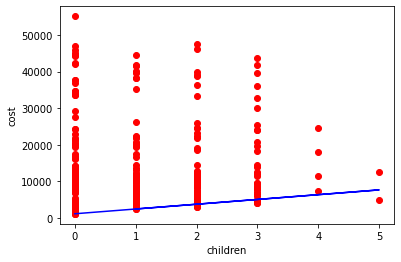

In [63]:
#children and Insurance Cost
X_train  = data_train.select("children")
X_test  = data_test.select("children")
model = GDLinearRegression(0.0001, 1000)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("Step")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('children')
plt.ylabel('cost')
plt.show()

x shape:  (1053, 2) - y shape:  (1053, 1) - weight shape:  (2, 1) train_size:  1053


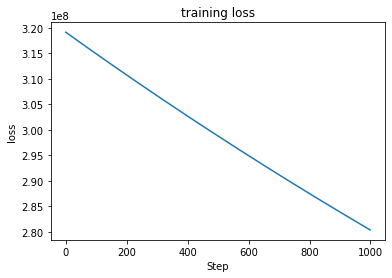

last loss:  280405370.1686803
[[ 1245.06967071 21344.8467    ]
 [ 1245.06967071  2203.73595   ]
 [ 1245.06967071  2211.13075   ]
 [ 1245.06967071 14133.03775   ]
 [ 1245.06967071  2217.46915   ]
 [ 1245.06967071  1634.5734    ]
 [ 1245.06967071  1694.7964    ]
 [ 1245.06967071  1704.5681    ]
 [ 1245.06967071  1704.70015   ]
 [ 1867.92229711 33732.6867    ]
 [ 1245.06967071  1137.4697    ]
 [ 1245.06967071  1141.4451    ]
 [ 1245.06967071  1149.3959    ]
 [ 1245.06967071  1728.897     ]
 [ 1245.06967071  2913.569     ]
 [ 1245.06967071  2709.1119    ]
 [ 1245.06967071  1737.376     ]
 [ 1867.92229711 16884.924     ]
 [ 1867.92229711 17468.9839    ]
 [ 1867.92229711 34439.8559    ]
 [ 1867.92229711 36397.576     ]
 [ 1245.06967071  2134.9015    ]
 [ 1245.06967071  2138.0707    ]
 [ 1245.06967071  1628.4709    ]
 [ 1867.92229711 16297.846     ]
 [ 1245.06967071  1639.5631    ]
 [ 1867.92229711 33750.2918    ]
 [ 1245.06967071  1261.859     ]
 [ 1867.92229711 34779.615     ]
 [ 1245.06967

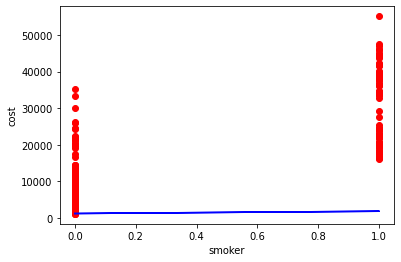

In [64]:
#smoking and Insurance Cost
X_train  = data_train.select("smoker_index")
X_test  = data_test.select("smoker_index")
model = GDLinearRegression(0.0001, 1000)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("Step")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('smoker')
plt.ylabel('cost')
plt.show()

x shape:  (1053, 2) - y shape:  (1053, 1) - weight shape:  (2, 1) train_size:  1053


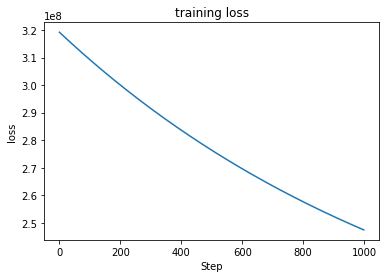

last loss:  247462646.57079384
[[ 5634.160563   21344.8467    ]
 [ 5634.160563    2203.73595   ]
 [ 5634.160563    2211.13075   ]
 [ 1138.2019723  14133.03775   ]
 [ 5634.160563    2217.46915   ]
 [ 1138.2019723   1634.5734    ]
 [ 5634.160563    1694.7964    ]
 [ 5634.160563    1704.5681    ]
 [ 5634.160563    1704.70015   ]
 [ 5634.160563   33732.6867    ]
 [ 1138.2019723   1137.4697    ]
 [ 1138.2019723   1141.4451    ]
 [ 1138.2019723   1149.3959    ]
 [ 4135.50769943  1728.897     ]
 [ 4135.50769943  2913.569     ]
 [ 2636.85483587  2709.1119    ]
 [ 4135.50769943  1737.376     ]
 [ 4135.50769943 16884.924     ]
 [ 2636.85483587 17468.9839    ]
 [ 1138.2019723  34439.8559    ]
 [ 4135.50769943 36397.576     ]
 [ 2636.85483587  2134.9015    ]
 [ 2636.85483587  2138.0707    ]
 [ 2636.85483587  1628.4709    ]
 [ 4135.50769943 16297.846     ]
 [ 2636.85483587  1639.5631    ]
 [ 2636.85483587 33750.2918    ]
 [ 4135.50769943  1261.859     ]
 [ 4135.50769943 34779.615     ]
 [ 4135.5076

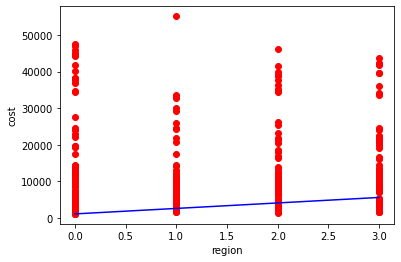

In [65]:
#region and Insurance Cost
X_train  = data_train.select("region_index")
X_test  = data_test.select("region_index")
model = GDLinearRegression(0.0001, 1000)
import numpy as np
model.fit(np.array(X_train.collect()), np.array(y_train.collect()))
train_loss = model.get_train_loss()
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)
plt.title("training loss")
plt.xlabel("Step")
plt.ylabel("loss")
plt.show()
print("last loss: ", train_loss[-1])

y_hat = model.predict(np.array(X_test.collect()))
print(np.concatenate((y_hat.reshape(len(y_hat), 1),np.array(y_test.collect()).reshape(len(np.array(y_test.collect())),1)),1))
# kiểm tra lại weight đã học được, khá gần với hệ số trong hàm số y = -3x + 5
model.print_weight()
plt.scatter(X_test.collect(), y_test.collect(), color="red")
plt.plot(X_test.collect(), y_hat, color="blue")
plt.xlabel('region')
plt.ylabel('cost')
plt.show()